In [35]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind,ttest_rel
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
sns.set_theme(style="white")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

# Plot part(semi-partial) correlation plot

In [36]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("(game2_fmri>=0.5)")
subjects_id = data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/cmap/alignPhi_cmap.nii.gz'

# set roi
roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')

# extract mean activity
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

data['Consistency_effect'] = subs_mean_activity

data['Inference_acc'] = data['game2_test_acc']
# zscore consistencey_effect
#data['Consistency_effect'] = (data['Consistency_effect'] - data['Consistency_effect'].mean())/data['Consistency_effect'].std()
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/tmp/ipykernel_1612011/3649204571.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Consistency_effect'] = subs_mean_activity
/tmp/ipykernel_1612011/3649204571.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

0.005663099937310613 0.9376977168631399


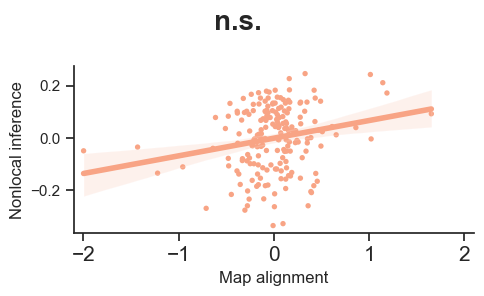

In [37]:
fig, ax = plt.subplots(figsize=(5,3))
# Fit regression model (using the natural log of one of the regressors)
# Fit regression models and get residuals
results1 = smf.ols('Inference_acc ~ Age', data=data).fit()
results2 = smf.ols('Consistency_effect ~ Age', data=data).fit()
# Create a new DataFrame with the residuals
resid_data = pd.DataFrame({
    'Consistency_effect_resid': results2.resid,
    'Inference_resid': results1.resid
})
# # Plot the residuals against one another


#data_remove  = data.query("-3<Consistency_effect<3")# #'#F8A485'
sns.regplot(x='Consistency_effect_resid', y='Inference_resid', data=resid_data,color='#e36570',scatter_kws={'s':15,'edgecolor':'None','alpha':1},line_kws={'linewidth':4})
# sns.regplot(x='Consistency_effect', y='Inference_acc', data=data,color='#F8A485',scatter_kws={'s':30,'edgecolor':'None','alpha':1},line_kws={'linewidth':4})
plt.xlabel('Map alignment')
plt.ylabel('Nonlocal inference')
# plt.xlabel('Map-alignment')
# plt.ylabel('Age')

#plt.yticks([-0.3,0,0.3],size=15)
plt.xticks([-2,-1,0,1,2],size=15)
# plt.ylim([-0.4,0.4])
plt.xlim([-2.1,2.1])

#move overall title up
fig.subplots_adjust(top=0.92)

r, p = pearsonr(data['Consistency_effect'], data['Age'])
print(r,p)
if p < 0.05:
    fig.suptitle('{}'.format(p2sign(p)),size=20,fontweight='bold')
else:
    fig.suptitle('{} '.format(p2sign(p)),size=20,fontweight='bold')

# save figure
fig.tight_layout()
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
savepath = r'/mnt/workdir/DCM/Result/paper/figure4/Game2_map-alignment_EC_Acc_Control_age_partial_corr.pdf'
plt.savefig(savepath, bbox_inches='tight', pad_inches=0, dpi=300, transparent=True)
plt.show()

In [9]:
import pingouin as pg

pg.partial_corr(data=data, x='Consistency_effect', y='Inference_acc', covar='Age',method='pearson')

,n,r,CI95%,p-val
pearson,193,0.210361,"[0.07, 0.34]",0.003404
